## History of "literature" - Page-level co-occurrence in Hathi Trust

So, to pick up where we left off last time. Over the course of the last two weeks, I've blocked in the code to do the basic page-level co-occurrence analysis, which turned out to be a bit more complex than I thought - though in some really interesting ways. After getting the overall counts for each token in each year (the "baseline" counts that I showed before), the next step was to extract a second, filtered set of counts that would record the number of times each word appeared on pages that contain "literature." Put together, these two sets of counts give us the building blocks that we need to track the diachronic change in a word's association with literature - find words that have a particularly volatile / dynamic / "trending" relationship with literature over time.

We're now storing two different types of counts in two tables:

```sql
CREATE TABLE count (
	token VARCHAR NOT NULL, 
	year INTEGER NOT NULL, 
	count INTEGER NOT NULL, 
	PRIMARY KEY (token, year)
);
CREATE TABLE anchored_count (
	token VARCHAR NOT NULL, 
	year INTEGER NOT NULL, 
	anchor_count INTEGER NOT NULL, 
	count INTEGER NOT NULL, 
	PRIMARY KEY (token, year, anchor_count)
);
```

The `count` table stores the overall, unfiltered counts for words on all pages, broken out by year. Eg:

**`"literature" / 1900 / 89608`**

Meaning, "literature" appears 89,608 times in 1900. Meanwhile, `anchored_count` stores counts just for words that appear on pages that contain literature, broken out by the year and by the number of times that "literature" itself appears on the page in question. (This will allow us to dig into the question of whether there's a difference between pages that are really _about_ literature, as opposed to pages that just use the word in passing.) Eg:

**`"poetry" / 1900 / 4 / 5967`**

Meaning - in 1900, "poetry" appears 5,967 times on pages where "literature" appears 4 times. In total, the extraction run chewed through all ~820k volumes in the Harvard collection in Hathi Trust, and observed a total of **43.5 billion** tokens:

In [1]:
from hol.models import Count, AnchoredCount

print(Count.total_token_count())

43401065888


Which is still only about 1/5 of the whole collection. It turns out, the Harvard collection is basically a C19 corpus. Here's the overall volume trend:

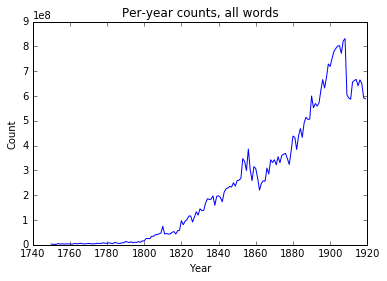

In [2]:
%matplotlib inline
import matplotlib.pyplot as plt

years = range(1750, 1920)

ts = Count.year_count_series(years)

plt.title('Overall token volume, all pages')
plt.xlabel('Year')
plt.ylabel('Count')
plt.plot(*zip(*ts.items()))

## The basic metric - log-likelihoods, ranked and scaled

So, two sets of counts - one for all pages, and the other just for pages that contain "literature." Even though both are drawn from the same corpus, we can think of them as representing two separate corpora - the corpus of "literature" pages, and the corpus of all pages, a sub-corpus and a super-corpus. What we want, is - which words appear in the literature corpus at a higher-than-expected rate, when compared against the overall frequencies in the super-corpus?

There are a couple of ways to go about this - a log-likelihood tests, the Mann-Whitney ranks tests, and others. The log-likelihood is the most canonical and straightforward, though, so let's start with that. To measure the distinctiveness of "great" in 1900, we need 4 pieces of information:

In [65]:
a = AnchoredCount.token_year_count('great', 1900)
print('The number of times "great" appears on pages that contain "literature":')
print(a, '\n')

b = Count.token_year_count('great', 1900)
print('The number of times "great" appears on all pages:')
print(b, '\n')

c = AnchoredCount.year_count(1900)
print('The total number of tokens observed on pages that contain "literature":')
print(c, '\n')

d = Count.year_count(1900)
print('Total number of tokens observed on all pages:')
print(d)

The number of times "great" appears on pages that contain "literature":
41986 

The number of times "great" appears on all pages:
925673 

The total number of tokens observed on pages that contain "literature":
23646454 

Total number of tokens observed on all pages:
719028426


Then, we can use scipy's `chi2_contingency` function to calculate the log-likelihood:

In [66]:
import numpy as np

from scipy.stats import chi2_contingency

g, p, dof, exp = chi2_contingency(
    np.array([[a, b], [c, d]]),
    lambda_='log-likelihood',
)

print(g)

3765.27132696


This is expensive to compute for an individual word, but it can be sped up by querying big batches of counts and calculating the scores in bulk. These get shoveled into a `score` table, which stores the token, year, log-likelihood ("score"), and a derived "rank" metric, which we'll look at in a moment:

```sql
CREATE TABLE score (
	token VARCHAR NOT NULL, 
	year INTEGER NOT NULL, 
	score FLOAT NOT NULL, 
	PRIMARY KEY (token, year)
);
```

So, once we've filled in this table with log-likelihood scores for each token in each year, we can generate a list of the words in a given year that are most associated with literature. Here's the list for 1900, pulling from pages that contain literature more than 5 times:

In [4]:
import pprint

from collections import OrderedDict
from hol.models import Score

topn = Score.topn_by_year(1900, 50)

scores = OrderedDict()
for token, (score, rank) in topn.items():
    scores[token] = score
    
pp = pprint.PrettyPrinter()
pp.pprint(scores)

OrderedDict([('english', 5995.673107665032),
             ('literary', 3820.5985417596894),
             ('history', 3705.8351214244103),
             ('professor', 3239.294100448038),
             ('language', 2290.153895401676),
             ('books', 2001.668119215872),
             ('american', 1687.7482990107574),
             ('book', 1642.570412227638),
             ('poetry', 1507.4949554457794),
             ('university', 1459.2288094651908),
             ('study', 1341.981826871721),
             ('prose', 1308.1927198202545),
             ('writers', 1282.4655070881258),
             ('authors', 1250.9792908355407),
             ('century', 1201.2861031609016),
             ('languages', 1110.6825168783676),
             ('of', 1026.6466562692985),
             ('german', 996.5862329926136),
             ('latin', 976.1989634215894),
             ('library', 963.2981365407198),
             ('reading', 894.3778861350803),
             ('was', 881.3246952594754),
           

This is fairly expensive to compute for an individual word, but it can be sped up by querying big batches of counts from the database and calculating the scores in bulk. These get indexed in a `score` table, which just stores the log-likelihood for each word in each year:

```sql
CREATE TABLE score (
	token VARCHAR NOT NULL, 
	year INTEGER NOT NULL, 
	score FLOAT NOT NULL, 
	PRIMARY KEY (token, year)
);
```

Querying against the complete set of ~1.3M log-likelihoods, we can generate a ranked lists that show the words most associated with literature in a given year:

In [27]:
import pprint

from hol.models import Score

topn = Score.topn_by_year(1900, 50)

pp = pprint.PrettyPrinter()
pp.pprint(topn)

OrderedDict([('english', 0.9999999999999999),
             ('literary', 0.9998570407433881),
             ('history', 0.9997140814867762),
             ('professor', 0.9995711222301643),
             ('language', 0.9994281629735524),
             ('books', 0.9992852037169406),
             ('american', 0.9991422444603287),
             ('book', 0.9989992852037168),
             ('poetry', 0.998856325947105),
             ('university', 0.9987133666904932),
             ('study', 0.9985704074338813),
             ('prose', 0.9984274481772694),
             ('writers', 0.9982844889206576),
             ('authors', 0.9981415296640457),
             ('century', 0.9979985704074338),
             ('languages', 0.9978556111508219),
             ('of', 0.9977126518942101),
             ('german', 0.9975696926375982),
             ('latin', 0.9974267333809863),
             ('library', 0.9972837741243745),
             ('reading', 0.9971408148677626),
             ('was', 0.9969978556111507),
 

Why does history get a score of 25.2 here, but 48722.2 when calculated directly? This is because the values indexed in the database get scaled to unit variance - centered around 0, with a standard deviation of 1. This is important because the raw log-likelihood scores are boosted up or down by the total volume of tokens, which varies significantly over time. By scaling the scores, we can compare them _across years_, instead of just being able to compare different words within an individual year.

So, now - for any word, we can query a time-series progression that represents the degree to which it tends to appear alongside literature. Eg, for "god" (0 means no association):

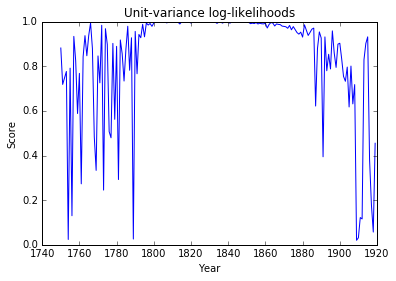

In [4]:
from hol.models import Score

years = range(1750, 1920)

poetry = Score.token_series('god', years)

plt.title('Unit-variance log-likelihoods')
plt.xlabel('Year')
plt.ylabel('Score')
plt.plot(*zip(*poetry.items()))

Smoothed with a 10-year window:

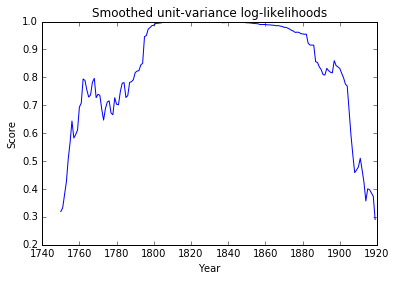

In [5]:
years = range(1750, 1920)

poetry = Score.token_series_smooth('god', years)

plt.title('Smoothed unit-variance log-likelihoods')
plt.xlabel('Year')
plt.ylabel('Score')
plt.plot(*zip(*poetry.items()))

Beyond just looking at the progressions for individual words, what we really want is to compare the trends for different words. Which words have the most "volatile" or "trending" signals - moving up and down, slowly approaching or fading over time? How to score the time series in a way that captures this? I think there are a number of different ways to go at this, and different approaches will pick out different things. For example, we could try to capture "peakiness," words that have a baseline value and then spike up or down significantly at one point or another. Or, we could try to find words that have a consistent up or down trend over time - words that gradually but consistently approach literature, or fall away from it.

As a start, though - and since the simplest model is often good, if not best - I just calculated the raw variance of the values in the time series. I think this may actually do a pretty good job of capturing a couple different types of this "dynamism" that we care about. Here are the top 20 words, in terms of variance:

In [28]:
years = range(1750, 1920)

tsv = Score.ranked_series(years)

for token, (series, variance) in list(tsv.items())[:20]:
    print(token, variance)

trent 0.09288887577
cars 0.0922160644189
dial 0.0813682625417
crucial 0.0785763931539
evolution 0.0736041597717
recover 0.0728752371777
grades 0.07256248603
taxes 0.0719626581207
mc 0.0697965841148
bonds 0.0696868458195
banner 0.069547412411
at 0.0691452802568
serial 0.0683969814391
after 0.067613843437
story 0.0671137501431
car 0.0667338564954
odds 0.0652013986319
book 0.0643558174
net 0.0638441751122
great 0.0634171179105


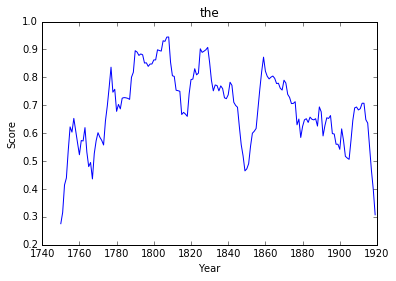

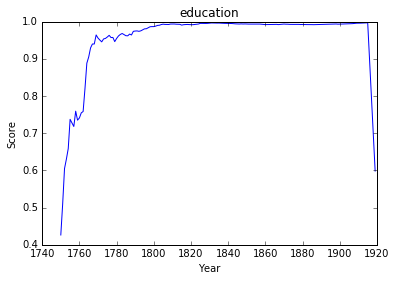

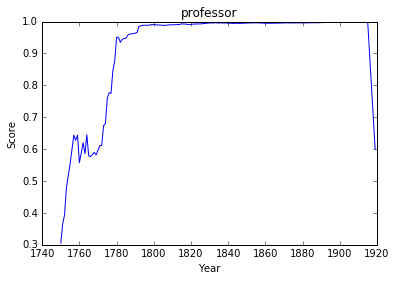

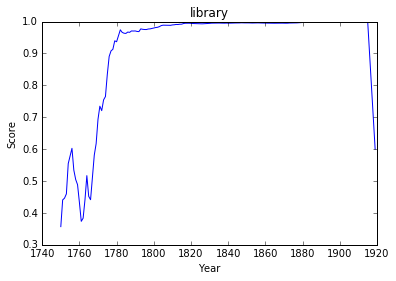

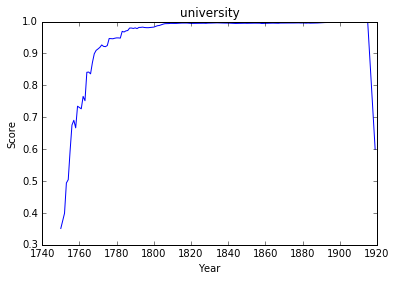

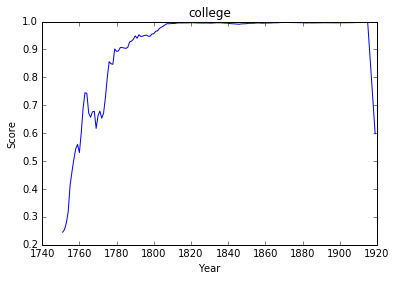

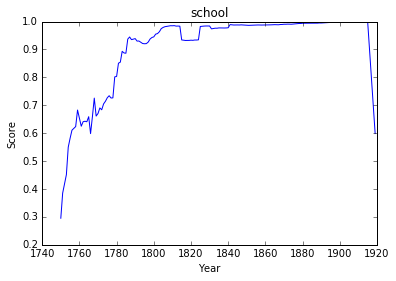

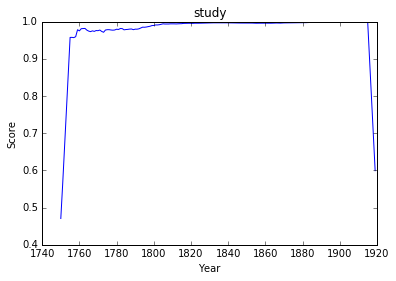

In [25]:
def plot_series(token, series):
    plt.title(token)
    plt.xlabel('Year')
    plt.ylabel('Score')
    plt.plot(*zip(*series.items()))
    plt.show()

plot_series('the', tsv['the'][0])
plot_series('education', tsv['education'][0])
plot_series('professor', tsv['professor'][0])
plot_series('library', tsv['library'][0])
plot_series('university', tsv['university'][0])
plot_series('college', tsv['college'][0])
plot_series('school', tsv['school'][0])
plot_series('study', tsv['study'][0])

## Trends

A couple of quick observations. Words related to education - the teaching of literature - tend to increase over time:

But interestingly "learning" and "knowledge" have the opposite trend:

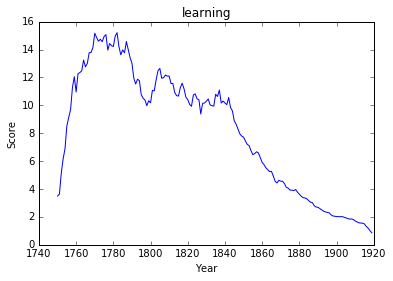

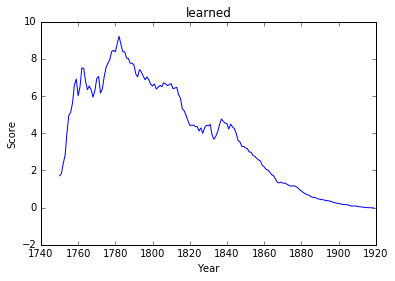

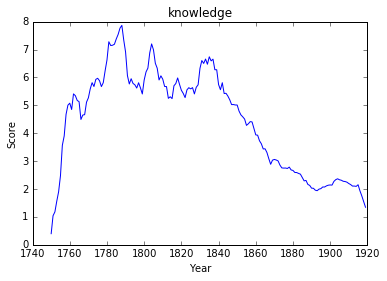

In [26]:
plot_series('learning', tsv['learning'][0])
plot_series('learned', tsv['learned'][0])
plot_series('knowledge', tsv['knowledge'][0])

As if - literature becomes less of a repository of information, of facts, and more of an aesthetic object? Indeed:

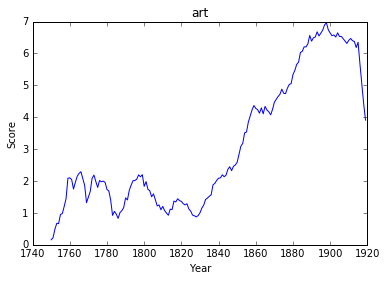

In [24]:
plot_series('art', tsv['art'][0])

And conversely, less "useful" over time:

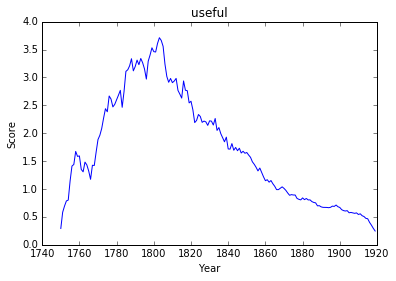

In [50]:
plot_series('useful', tsv['useful'][0])

Other things. Literature becomes feminized in C19?

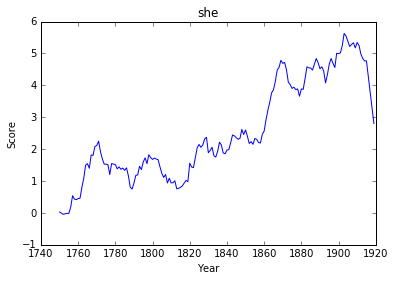

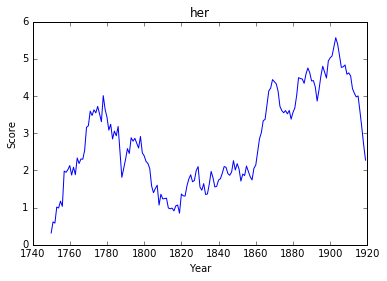

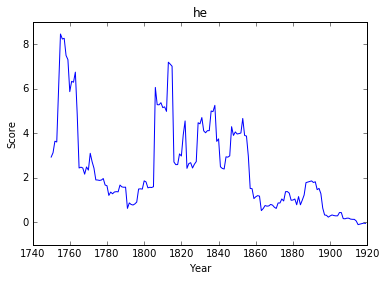

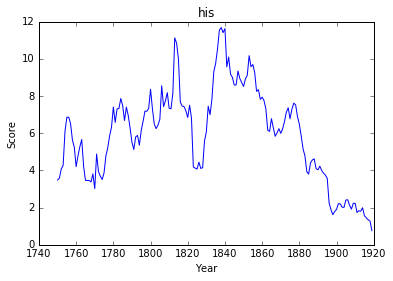

In [31]:
plot_series('she', tsv['she'][0])
plot_series('her', tsv['her'][0])
plot_series('he', tsv['he'][0])
plot_series('his', tsv['his'][0])

Romantic "genius" is well-defined:

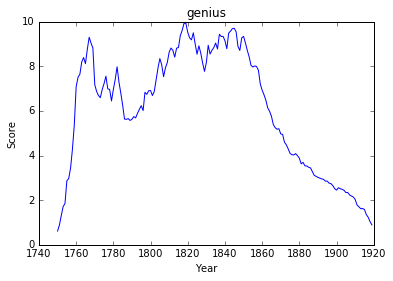

In [36]:
plot_series('genius', tsv['genius'][0])

"God" and "Christ" do well in the first half of the 18th century:

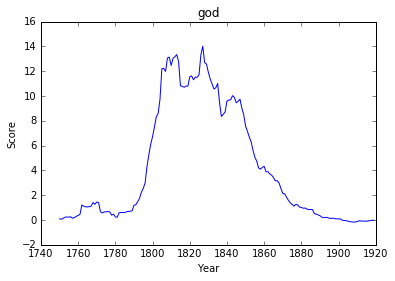

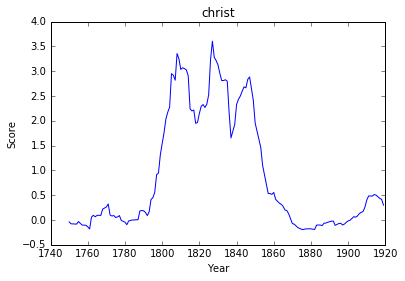

In [34]:
plot_series('god', tsv['god'][0])
plot_series('christ', tsv['christ'][0])

Literature seems to become associated with the judicial system over time:

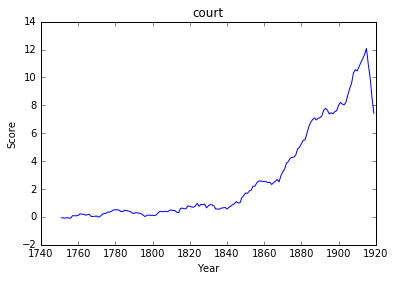

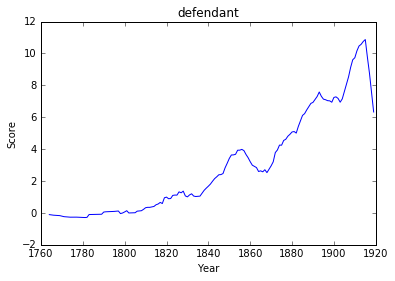

In [40]:
plot_series('court', tsv['court'][0])
plot_series('defendant', tsv['defendant'][0])

And likewise, with business:

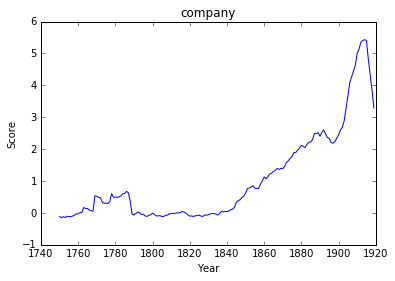

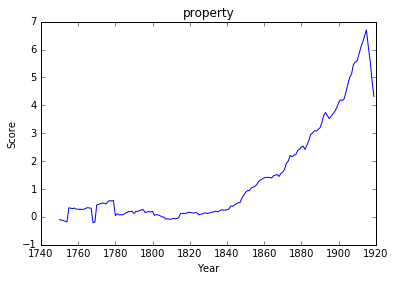

In [48]:
plot_series('company', tsv['company'][0])
plot_series('property', tsv['property'][0])

The literary field becomes more "dialogic"?

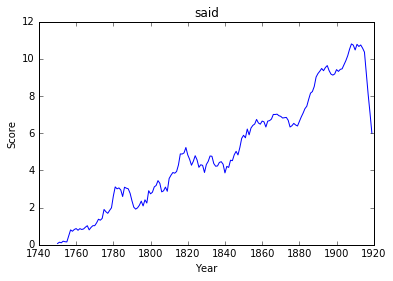

In [41]:
plot_series('said', tsv['said'][0])

What you read becomes less a matter of taste, less of a form of expression?

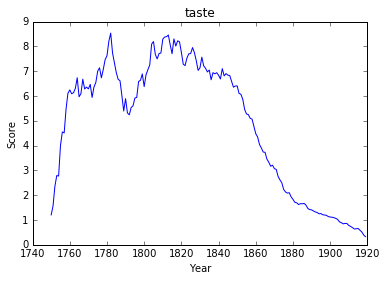

In [43]:
plot_series('taste', tsv['taste'][0])

What in the world is up with "cloth"? Is this something about the history of book binding?

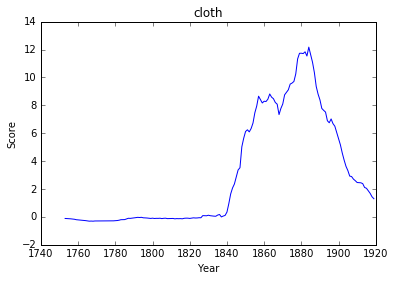

In [42]:
plot_series('cloth', tsv['cloth'][0])

Or "arrived," which I can't even hazard a guess about:

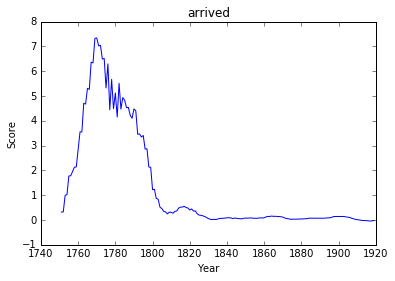

In [44]:
plot_series('arrived', tsv['arrived'][0])

One more - "popularity" peaks out in 1860-1880, and then falls off precipitously:

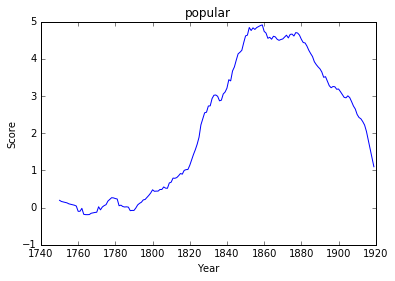

In [52]:
plot_series('popular', tsv['popular'][0])

## Questions, uncertainties

- Why do some stopwords (eg, "of") show up in the MDW lists computed from the log-likelihoods? The lists generally look good to my eye, but this seems odd, and makes me wonder if there's a better approach.

- What's the best way to evaluate the "volatility" of the time series? Can this be significance tested?

- Is it valid to scale the log-likelihoods to unit-variance and then compare across years? I think this works, but it's important to be sure.

- The Harvard collection is very C19 heavy, I think moreso than the rest of Hathi. I'd like to go ahead and run this on the complete corpus.

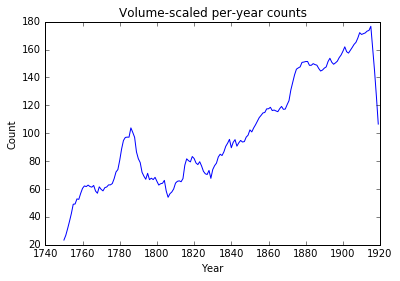

In [63]:
years = range(1750, 1920)

series = Count.token_wpm_series_smooth('payment', years)

plt.title('Volume-scaled per-year counts')
plt.xlabel('Year')
plt.ylabel('Count')
plt.plot(*zip(*series.items()))